# Create and run a local RAG pipeline (From Scratch)

By **Purinat Pattanakeaw**

Following a tutorial by [Daniel Bourke](<https://youtu.be/qN_2fnOPY-M>)

## What is a RAG

RAG stands for **Retrieval Augmented Generation**. The goal of RAG is to have specific information and pass it to an LLM so it can generate outputs more specific based on that information.

1. **Retrieval**: Find relevant information given a query.
2. **Augmentation**: Take the relevant information and *augment* our input (prompt) to an LLM with that relevant information.
3. **Generation**: Take the first two steps and pass them to an LLM for a generative output.

Asking existing chatbots with broad data (eg. OpenAI) can have:

1. No real-time information
2. AI will Hallucinates (make up random answer)
3. No custom, more specific data

## Important Concepts:
1. Text Embedding
2. Vector Database

## Why Local
1. Cool
2. Privacy: Don't want to send company's data via API
3. Speed: No need to send data across the internet.
4. Cost: No API fee
5. No Vendor Lockin: If OpenAI exploded tomorrow, we can still operate.

In [265]:
!nvidia-smi

Fri Jun 28 16:27:20 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.99                 Driver Version: 555.99         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060      WDDM  |   00000000:01:00.0  On |                  N/A |
| 38%   39C    P8             N/A /  120W |    3303MiB /   8188MiB |      7%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Sample

We will be using the ICT curriculum because why not?

1. We slice the file into smaller chunks of text as "context"
2. Embed the texts into numerical format using embedding models
3. Store them in database or PyTorch tensors

## What we are doing

### Document Preprocessing and Embedding Creation

1. Open a PDF document (or even a collections of PDFs)
2. Format the text of the PDF ready for an embedding model.
3. Embed all of the chunks of text in the textbook and turn them into numerical representations (embedding) which we can store for later.

### Search and Answer

4. Build a retrieval system that uses **Vector Search** to find relevant chunk of text based on a *query*.
5. Create a prompt that incorporates the retrieved pieces of text.
6. Generate an answer to a query based on the passages of the textbook with an LLM.

<hr>

# Steps:

## 1. Document Preprocessing and Embedding Creation

**Requirement**:
1. PDF Document (or any type of document)
2. Embedding Model of choice

**Steps**:
1. Import PDF document.
2. Process text for embedding 
    * (eg. splitting into chunks of sentenses)
3. Embed text chunks with embedding model
4. Save embeddings to file

### 1.1 Import PDF Document

In [266]:
import os
import requests

# Get PDF document path
pdf_path = "curriculum.pdf"

# Download PDF
if not os.path.exists(pdf_path):
    print(f"{pdf_path} does not exist")
    
    # Enter the URL of the PDF
    url = "https://www.ict.mahidol.ac.th/wp-content/uploads/2021/05/ICT2018-TQF2_Webversion_English.pdf"
    
    # The local filename to save the downloaded file
    filename = pdf_path
    
    # Send a GET request to the URL
    response = requests.get(url)
    
    # Check if successful
    if response.status_code == 200:
        # Open the file and save it
        with open(filename, "wb") as f:
            f.write(response.content)
        print(f"File {filename} downloaded")
    else:
        print(f"Failed to download file: {response.status_code}")
        
else:
    print(f"File {pdf_path} Existed: Skipping")

File curriculum.pdf Existed: Skipping


### 1.2 Open PDF Document

There are multiple PDF-related modules, the tutorial uses [PyMuPDF](https://pymupdf.readthedocs.io/en/latest/)

In [267]:
import fitz # PyMuPDF (Fitz is legacy/backward compatible)
print(fitz.__doc__)

None


In [268]:
# Progress Bar looks cool
from tqdm.auto import tqdm
print(tqdm.__doc__)


    Asynchronous-friendly version of tqdm.
    


In [269]:
# Perform text formatting
# Because raw PDF copy-pasting doesn't really work well
def text_formatter(text: str) -> str:
    """Performs minor formatting on text

    Args:
        text (str): _description_

    Returns:
        str: Formatted Text through various functions
    """
    
    # Strip trailing spaces
    # Replace "\n" with " "
    cleaned_text = text.replace("\n", " ").strip()
    
    # Potentially more text formatting functions go here
    # Better text = Better LLM
    
    return cleaned_text

In [270]:
def read_pdf(pdf_path: str) -> list[dict]:
    doc = fitz.open(pdf_path)
    pages_and_texts = []
    
    # Loop through the doc with tqdm progress bar 
    # Page number and page content
    for page_number, page in tqdm(enumerate(doc)):
        text = page.get_text()
        text = text_formatter(text=text)
        # Experiment with page number if you want
        pages_and_texts.append({
            "page_number": page_number - 6, # Page number start appearing at page 4
            "page_char_count": len(text),
            "page_word_count": len(text.split(' ')),
            "page_sentence_count_raw": len(text.split('. ')),
            "page_token_count": len(text) / 4, # 1 English Word = ~4 tokens
            "text": text
                                })
    
    return pages_and_texts

**Token**: A sub-word pieve of textA sub-word piece of text. For example, "hello, world!" could be split into ["hello", ",", "world", "!"]. 

A token can be a whole word,
part of a word or group of punctuation characters. 1 token ~= 4 characters in English, 100 tokens ~= 75 words.
Text gets broken into tokens before being passed to an LLM.. 

### 1.3 Testing parsing and reading of PDF

In [271]:
# Testing
pages_and_text = read_pdf(pdf_path=pdf_path)
pages_and_text[:2] # First 2 samples

106it [00:00, 535.30it/s]


[{'page_number': -6,
  'page_char_count': 198,
  'page_word_count': 41,
  'page_sentence_count_raw': 1,
  'page_token_count': 49.5,
  'text': 'Bachelor of Science   in Information and Communication Technology (ICT)  (International Program)  2018 Revision                Faculty of Information and Communication Technology  Mahidol University'},
 {'page_number': -5,
  'page_char_count': 5270,
  'page_word_count': 341,
  'page_sentence_count_raw': 65,
  'page_token_count': 1317.5,
  'text': 'Table of Contents  SECTION 1.  GENERAL INFORMATION  .......................................................................................................................................... 1  1.  PROGRAM TITLE ..................................................................................................................................................................... 1  2.  DEGREE TITLE .............................................................................................................

In [272]:
# Random sample
import random
random.sample(pages_and_text, k=1)

[{'page_number': 27,
  'page_char_count': 1561,
  'page_word_count': 309,
  'page_sentence_count_raw': 2,
  'page_token_count': 390.25,
  'text': 'Degree    \uf052 Bachelor       Master        Ph.D.                 Information and Communication Technology  TQF2 Bachelor of Science in Information and Communication Technology (International Program)                 30    writing short articles and technical reports; intermediate grammar; vocabulary related to  computers and information technology  ITLG 104  Elementary German I  2 (1 – 2 – 3)  Prerequisite    : None  Co-requisite : None     A practice of basic usage of the German language: listening, speaking, reading, and  writing, with an emphasis on basic communication skill in listening and speaking; basic grammar  and reading comprehension skills; basic conversations for everyday life; vocabulary related to  computer and information technology   ITLG 105  Elementary German II  2 (1 – 2 – 3)  Prerequisite    : ITLG 104  Co-requisite :

### 1.4 Performing some exploratory analysis

In [273]:
import pandas as pd

# The reason we made it a list of dictionary
df = pd.DataFrame(pages_and_text)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-6,198,41,1,49.50,Bachelor of Science in Information and Commu...
1,-5,5270,341,65,1317.50,Table of Contents SECTION 1. GENERAL INFORMA...
2,-4,1495,86,15,373.75,SECTION 6: ACADEMIC STAFF DEVELOPMENT ...........
3,-3,1252,273,10,313.00,Degree  Bachelor Master Ph.D....
4,-2,1630,314,13,407.50,Degree  Bachelor Master Ph.D....


In [274]:
df.describe()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,106.000000,106.000000,106.000000,106.000000,106.000000
mean,46.500000,1787.084906,377.443396,7.094340,446.771226
std,30.743563,474.917479,127.838520,8.356951,118.729370
min,-6.000000,198.000000,41.000000,1.000000,49.500000
25%,20.250000,1594.500000,322.000000,2.000000,398.625000
50%,46.500000,1801.000000,349.000000,2.500000,450.250000
75%,72.750000,1951.750000,387.000000,11.000000,487.937500
max,99.000000,5270.000000,812.000000,65.000000,1317.500000


**Average Token Per Page**: `447`

Why care about Token?

Token is important concept because:
1. Embedding Models don't deal with infinite tokens.
2. LLMs don't deal with infinite tokens.

For example an embedding model may be trained to embed sequence of `384` tokens into numerical space. 

As for LLMs, they can't accept infinite number of Tokens into their **LLM Context Window**.


### 1.5 Splitting each page into sentences

Possible Ways:
1. Splitting on `"."`
2. Using an NLP library eg. nltk, spacy

In [275]:
from spacy.lang.en import English

nlp = English()

# Build a sentencizer pipeline.
nlp.add_pipe("sentencizer")

# Create document instance as an exxample.
doc = nlp("This is a sentence. This is another sentence, according to this. Hello World!")
assert len(list(doc.sents)) == 3

# Print out our sentences split
list(doc.sents)

[This is a sentence.,
 This is another sentence, according to this.,
 Hello World!]

In [276]:
pages_and_text[0]

{'page_number': -6,
 'page_char_count': 198,
 'page_word_count': 41,
 'page_sentence_count_raw': 1,
 'page_token_count': 49.5,
 'text': 'Bachelor of Science   in Information and Communication Technology (ICT)  (International Program)  2018 Revision                Faculty of Information and Communication Technology  Mahidol University'}

In [277]:
for item in tqdm(pages_and_text):
    item["sentences"] = list(nlp(item["text"]).sents)
    
    # Make sure all sentences are strings (Default = Spacy)
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]
    
    # Count the sentences
    item["page_sentence_count_spacy"] = len(item['sentences'])

100%|██████████| 106/106 [00:00<00:00, 379.76it/s]


In [278]:
random.sample(pages_and_text, k=1)

[{'page_number': 26,
  'page_char_count': 1602,
  'page_word_count': 325,
  'page_sentence_count_raw': 2,
  'page_token_count': 400.5,
  'text': 'Degree    \uf052 Bachelor       Master        Ph.D.                 Information and Communication Technology  TQF2 Bachelor of Science in Information and Communication Technology (International Program)                 29    and scientific problems using computation models; using software developed for mathematical and  scientific computation; creation of virtual world that represents a physical world; study of human being’s  relationship to the digital world; modeling physical systems using software and hardware that can sense  and respond to the real world environment    • Languages  no less than 12 Credits  Number of credits (Lecture – Laboratory – Self-study)  ITLG 101  Technical English I  2 (1 – 2 – 3)  Prerequisite    : None  Co-requisite : None     English language skills for university level course work; emphasis on basic  communicat

In [279]:
df = pd.DataFrame(pages_and_text)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,106.00,106.00,106.00,106.00,106.00,106.00
mean,46.50,1787.08,377.44,7.09,446.77,5.10
std,30.74,474.92,127.84,8.36,118.73,5.99
min,-6.00,198.00,41.00,1.00,49.50,1.00
25%,20.25,1594.50,322.00,2.00,398.62,1.00
50%,46.50,1801.00,349.00,2.50,450.25,1.00
75%,72.75,1951.75,387.00,11.00,487.94,8.00
max,99.00,5270.00,812.00,65.00,1317.50,33.00


### 1.6 Chunking sentences together

The concept of splitting larger pieces of text intoo smaller ones is often referred to as text splitting or chunking.

Reasons:
1. Easier to filter.
2. Can fit into embedding model context window
3. LLM can have more specific and focused contexts

Try experimenting with chunk size if wanted.

Tools such as LangChain can be used.

In [280]:
num_sentence_chunk_size = 8

# A function to split lists of texts recursively into chunk size
def split_list(input_list: list[str], slice_size: int=num_sentence_chunk_size) -> list[list[str]]:
    return [input_list[i:i+slice_size] for i in range(0, len(input_list), slice_size)]

test_list = list(range(25))
split_list(test_list)

[[0, 1, 2, 3, 4, 5, 6, 7],
 [8, 9, 10, 11, 12, 13, 14, 15],
 [16, 17, 18, 19, 20, 21, 22, 23],
 [24]]

In [281]:
# Loop through pages and texts and split sentences into chunks
for item in tqdm(pages_and_text):
    item["sentence_chunk"] = split_list(input_list=item['sentences'],
                                        slice_size=num_sentence_chunk_size)
    item["num_chunk"] = len(item['sentence_chunk'])

100%|██████████| 106/106 [00:00<00:00, 105279.71it/s]


In [282]:
random.sample(pages_and_text, k=1)

[{'page_number': 85,
  'page_char_count': 1896,
  'page_word_count': 665,
  'page_sentence_count_raw': 2,
  'page_token_count': 474.0,
  'text': 'Degree    \uf052 Bachelor       Master        Ph.D.                 Information and Communication Technology  TQF2 Bachelor of Science in Information and Communication Technology (International Program)                 88    13 ITCS 437 Project Management and Practice  3(3-0-6)  R  I  R  R            14 ITCS 445 Data Science  3(3-0-6)  R  R        R  R  R    15 ITCS 463  Modern Enterprise Resource Planning in  Organization  3 (2-2-5)  R  R    R    R        16 ITCS 497 Independent Study  3(3-0-6)      M            M/A  17 ITCS 499 Cloud Computing Systems, Services and  Applications  3(3-0-6)  R  R        R  R  R      I      :  Introduced  R :  Reinforced and opportunity to practice     M    :  Mastery   A :  Assessment evidence collected    Table Appendix 2.2  Curriculum Mapping according to program structure  Course Code and Name  Number of  

In [283]:
df = pd.DataFrame(pages_and_text)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunk
count,106.00,106.00,106.00,106.00,106.00,106.00,106.00
mean,46.50,1787.08,377.44,7.09,446.77,5.10,1.30
std,30.74,474.92,127.84,8.36,118.73,5.99,0.65
min,-6.00,198.00,41.00,1.00,49.50,1.00,1.00
25%,20.25,1594.50,322.00,2.00,398.62,1.00,1.00
50%,46.50,1801.00,349.00,2.50,450.25,1.00,1.00
75%,72.75,1951.75,387.00,11.00,487.94,8.00,1.00
max,99.00,5270.00,812.00,65.00,1317.50,33.00,5.00


### 1.7 Splitting each chunk into its own item

We'd like to embed each chunk of sentences into its own numerical representation.

That'll give us a good level of granularity

Meaning, we can dive specifically into the text sample that used in the model.

In [284]:
import re

# Split each chunk into its own item
pages_and_chunk = []
for item in tqdm(pages_and_text):
    for sentence_chunk in item['sentence_chunk']:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]
        
        # Join the sentences together into a paragraph-like structure.
        joined_sentence_chunk = "".join(sentence_chunk).replace(" ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # ".A" => ". A"
        
        chunk_dict['sentence_chunk'] = joined_sentence_chunk
        
        # Get some stats on the chunks
        chunk_dict['chunk_char_count'] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict['chunk_token_count'] = len(joined_sentence_chunk) / 4 # 1 token = ~4 chars
        
        pages_and_chunk.append(chunk_dict)
        
len(pages_and_chunk)

100%|██████████| 106/106 [00:00<00:00, 35321.86it/s]


138

In [285]:
random.sample(pages_and_chunk, k=1)

[{'page_number': 87,
  'sentence_chunk': 'Degree    \uf052 Bachelor       Master        Ph. D.                 Information and Communication Technology  TQF2 Bachelor of Science in Information and Communication Technology (International Program)                 90    Course Code and Name  Number of  Credits  Learning Outcomes (LOs)  Program Learning Outcomes  Stream Learning Outcomes  PLO1 PLO2 PLO3 PLO4 PLO5 SLO6 SLO7 SLO8 SLO9  6 ITCS 443 Parallel and Distributed Systems  3(3-0-6)  R  R                7 ITCS 361 Management Information Systems  3(3-0-6)  R  R  R      I        Year 3, Semester 2  1 ITLG 302 Academic Writing  2(1-2-3)  R        M/A      R    2 ITCS 424 Wireless and Mobile Computing  3(3-0-6)  R  R        I        3 ITCS 461 Computer and Communication Security  3(3-0-6)  R  R    R            4 ITCS 337 Human Computer Interaction  3(3-0-6)  R  R  R  R      I    R  5 ITCS 391 Computer Network Lab  1(0-2-1)  R  R                 Specialty 8 Track Courses  6 ITCS 431 Softwar

In [286]:
df = pd.DataFrame(pages_and_chunk)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,138.00,138.00,138.00,138.00
mean,43.75,1371.71,289.17,342.93
std,32.80,555.78,168.62,138.95
min,-6.00,119.00,4.00,29.75
25%,11.00,1044.25,171.75,261.06
50%,44.50,1519.00,310.50,379.75
75%,73.75,1809.50,352.75,452.38
max,99.00,2273.00,813.00,568.25


### 1.8 Filter chunks of text for short chunks

Since these chunks might not contain many useful information

In [287]:
# Show random chunks with less than 50 tokens
min_token_length = 50
for row in df[df['chunk_token_count'] <= min_token_length].iterrows():
    print(f"Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}")

Chunk token count: 49.5 | Text: Bachelor of Science   in Information and Communication Technology (ICT)  (International Program)  2018 Revision                Faculty of Information and Communication Technology  Mahidol University
Chunk token count: 44.75 | Text: STUDENT APPEAL ................................................................................................................................................................. 77
Chunk token count: 29.75 | Text: In: the 2nd International  Conference on Information  Technology (InCIT), 2017 Nov 2-3;  Nakhon Pathom, Thailand; 2017.
Chunk token count: 40.25 | Text: 4.2  Identify the code of ICT-related ethics (e.g. policy, law). 4.3  Express the awareness of business, social, security,  professional, and ICT-related ethics.
Chunk token count: 35.75 | Text: 8.3  Analyze, design, and develop solutions for research  problems. 8.4  Evaluate the solutions. 8.5  Prepare a research paper for publication.


In [288]:
# Filter our DataFrame for rows with under 30 tokens
pages_and_chunk_over_min_token_length = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunk_over_min_token_length[:2]

[{'page_number': -5,
  'sentence_chunk': 'Table of Contents  SECTION 1. GENERAL INFORMATION  .......................................................................................................................................... 1  1. PROGRAM TITLE ..................................................................................................................................................................... 1  2. DEGREE TITLE ........................................................................................................................................................................ 1  3. MAJOR OR MINOR SUBJECTS (IF ANY) ....................................................................................................................................... 1  4. TOTAL NUMBER OF CREDITS .................................................................................................................................................... 1  5. PROGRAM CHARACTERISTICS ..........

## 2. Embedding the text chunks

Embedding is an important concept. While human understands text, machines understand numbers.

TODO:
1. Turn the text chunks into useful numerical representation.

Embedding is already a **Learned Representation**, meaning that they already have some sort of mapping words to numbers, sentences to numbers etc.

Ref: [Vickiboykis.com/what_are_embeddings](<https://Vickiboykis.com/what_are_embeddings>)

### 2.1 Getting an Open-Source (Free) Embedding Model

eg:
1. Transformer Library
2. HuggingFace

Various dimensions, max tokens etc. for variety.

In [289]:
# https://sbert.net/
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2") # Or use other model from sbert

# List of sentences
sentences = [
    "The sentence transformer library in Python will provide a convenient way to create an embedding model for our LLM",
    "Sentences can be embedded one at a time or as a whole list",
    "He plays Elden Ring"
]

# Sentences are then encoded and embeded using model.encode()
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

# See the embedding
for sentence, embedding in embeddings_dict.items():
    print(f"Sentence: {sentence}")
    print(f"Embedding: {embedding}")
    print('')

c:\Users\User\miniconda3\envs\llm\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Sentence: The sentence transformer library in Python will provide a convenient way to create an embedding model for our LLM
Embedding: [ 2.33592596e-02  7.65010715e-03 -3.25721106e-03  5.62376454e-02
 -2.78488006e-02  1.39634376e-02 -1.42549509e-02 -1.11396220e-02
  3.03600356e-02 -7.68511146e-02  1.01084337e-02  2.70497426e-02
 -4.93733585e-02  4.27146023e-03  3.42298150e-02 -3.72172557e-02
  3.39534134e-02 -8.74367892e-04 -2.54810303e-02  3.67035046e-02
 -2.60433881e-03  4.54806536e-03  2.65060784e-03  3.28643993e-02
 -2.76557971e-02 -1.52009949e-02 -1.41041940e-02  2.15806887e-02
  3.82281989e-02 -2.34311186e-02 -1.51765412e-02  1.66700594e-02
  3.46966684e-02 -3.19524929e-02  1.15220803e-06 -3.60985026e-02
 -3.87522168e-02 -2.79415715e-02 -4.43816185e-03  9.47822758e-04
  4.93406020e-02 -3.67442891e-02 -7.99418055e-03  2.38510892e-02
 -6.35800213e-02  6.14589117e-02  1.51108736e-02  5.28505966e-02
  6.84414729e-02  1.05063662e-01 -1.09240348e-02 -4.80470248e-02
  2.63744388e-02 -7.

The model have converted each sentence into numbers (https://huggingface.co/sentence-transformers/all-mpnet-base-v2). Checking shape now:

In [290]:
embeddings[0].shape # 768 numbers to represent ONE sentence

(768,)

We *embed* all the sentences and we compare the input prompt's embed value with potential answer's embed, the higher the value, the more likely it is related to the question. 

eg (made up numbers):

**Sorce**: I like milk

**Answers**:
1. Calcium is strong for the bones. (47%)
2. Cheap livestock shop list (60%)
3. Tractor color (30%)
4. You like machine learning (2%)


In [291]:
embedding = embedding_model.encode("I like milk.")
embedding

array([ 3.29155549e-02,  9.56299976e-02, -1.85288340e-02, -3.28779072e-02,
        1.94535255e-02,  5.49064614e-02, -4.99018654e-02, -8.10288452e-03,
        6.84753060e-02,  3.75885027e-03,  2.88886111e-03, -3.35996002e-02,
        5.52557502e-03,  4.89195660e-02, -1.82248540e-02, -2.21181847e-02,
        2.82817911e-02,  1.79584697e-02,  7.78875127e-02,  1.35696065e-02,
       -2.57396651e-03,  1.04286447e-02, -2.17716321e-02, -3.28772664e-02,
       -3.96525953e-03,  1.18092215e-02,  2.69057136e-02, -4.38594595e-02,
        4.80882637e-02,  5.92225417e-02, -2.26736795e-02,  2.50691324e-02,
       -4.27515134e-02, -3.26632075e-02,  1.42373324e-06, -8.78988858e-03,
       -1.59406066e-02,  3.07522286e-02, -5.24568779e-04,  3.38814221e-02,
        7.55067263e-03, -3.28946933e-02, -1.28630465e-02, -3.41370180e-02,
       -1.87201705e-02,  1.11997366e-01,  6.01977892e-02, -2.74671298e-02,
       -2.47906782e-02,  8.13442934e-03, -1.19801741e-02, -3.94501947e-02,
       -1.07321665e-01, -

In [292]:
%%time

to_device = "cuda" if torch.cuda.is_available() else "cpu"

embedding_model.to(to_device)

# Embed each chunk
for item in tqdm(pages_and_chunk_over_min_token_length):
    item['embedding'] = embedding_model.encode(item['sentence_chunk'])

100%|██████████| 133/133 [00:02<00:00, 65.46it/s]

CPU times: total: 6.23 s
Wall time: 2.04 s


In [293]:
# %%time

# text_chunks_embeddings = embedding_model.encode(text_chunks,
#                                                 batch_size=32, 
#                                                 convert_to_tensor=True) # Can experiment with the size you want
# text_chunks_embeddings


### 2.2 Save Embeddings to Files

In [294]:
text_chunks_and_embedding_df = pd.DataFrame(pages_and_chunk_over_min_token_length)
embedding_df_save_path = "text_chunks_and_embedding_df.csv"
text_chunks_and_embedding_df.to_csv(embedding_df_save_path, index=False)

In [295]:
# Import saved file
text_chunks_and_embedding_df_load = pd.read_csv(embedding_df_save_path)
text_chunks_and_embedding_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-5,Table of Contents SECTION 1. GENERAL INFORMAT...,1267,58,316.75,[-2.19847802e-02 -4.61262427e-02 -2.79324148e-...
1,-5,THE ABILITY TO IMPLEMENT/PROMOTE THE PROGRAM ...,1125,87,281.25,[ 4.71613593e-02 -3.63593213e-02 -2.35828217e-...
2,-5,PROGRAM SPECIFIC INFORMATION ....................,1283,70,320.75,[ 5.78025775e-03 -4.24177051e-02 -2.10961681e-...
3,-5,FIELD EXPERIENCE COURSES (INTERNSHIP OR COOPER...,1380,90,345.00,[ 1.33792264e-02 -8.28028247e-02 -2.78722942e-...
4,-4,SECTION 6: ACADEMIC STAFF DEVELOPMENT ...........,1490,81,372.50,[ 5.83376065e-02 -6.44410923e-02 -1.28114251e-...


For large embedding database (100k+), consider using **Vector Database**

## 3. Search and Answer (RAG)

Goal: Retrieve relevant passages based on a query and use those passages to augment an input to an LLM so it can generate an output based on those relevant passages.

### 3.1 Similarity Search

Embeddings can be used for almost any type of data. eg. Images and sounds.

Comparing embeddings is known as **Similarity Search, Vector Search, Semantic Search**, while not containing the word itself, it's about the context and relevancy.

Whereas with **Keyword Search**, if we search "Computer" we should get passages back with "Computer".

In [296]:
import random
import torch
import numpy as np
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

# Import texts and embedding df
text_chunks_and_embedding_df = pd.read_csv("text_chunks_and_embedding_df.csv")

# Convert embedding column back to numpy array (It's String when converted and save to CSV)
text_chunks_and_embedding_df['embedding'] = text_chunks_and_embedding_df['embedding'].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# Then save it to a pytorch tensor
embeddings = torch.tensor(np.stack(text_chunks_and_embedding_df['embedding'].tolist(), axis=0), dtype=torch.float32).to(device=device)


# Convert texts and embedding df to list of dicts
pages_and_chunk = text_chunks_and_embedding_df.to_dict(orient="records")

text_chunks_and_embedding_df

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-5,Table of Contents SECTION 1. GENERAL INFORMAT...,1267,58,316.75,"[-0.0219847802, -0.0461262427, -0.0279324148, ..."
1,-5,THE ABILITY TO IMPLEMENT/PROMOTE THE PROGRAM ...,1125,87,281.25,"[0.0471613593, -0.0363593213, -0.0235828217, 0..."
2,-5,PROGRAM SPECIFIC INFORMATION ....................,1283,70,320.75,"[0.00578025775, -0.0424177051, -0.0210961681, ..."
3,-5,FIELD EXPERIENCE COURSES (INTERNSHIP OR COOPER...,1380,90,345.00,"[0.0133792264, -0.0828028247, -0.0278722942, -..."
4,-4,SECTION 6: ACADEMIC STAFF DEVELOPMENT ...........,1490,81,372.50,"[0.0583376065, -0.0644410923, -0.0128114251, -..."
...,...,...,...,...,...,...
128,95,Degree  Bachelor Master Ph. D...,1200,307,300.00,"[0.0169025138, -0.0259401686, -0.0390770957, -..."
129,96,Degree  Bachelor Master Ph. D...,1411,273,352.75,"[0.0908453614, -0.00180858572, -0.0493984669, ..."
130,97,Degree  Bachelor Master Ph. D...,1352,313,338.00,"[0.0475489125, -0.0543984883, -0.0493552461, -..."
131,98,Degree  Bachelor Master Ph. D...,1456,278,364.00,"[0.0376859568, -0.00997580402, -0.0466063842, ..."


In [297]:
embeddings.shape

torch.Size([133, 768])

In [298]:
# Create model
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device=device)

c:\Users\User\miniconda3\envs\llm\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Creating a small semantic search pipeline

Search for a query (eg. "Video Editing") and get back relevant passages from the pdf.

1. Define a query string
2. Turn the query string into an embedding.
3. Perform a dot product or cosine similarity function between the text embeddings and the query embedding. (Vector stuff)
4. Sort the results in descending order.

In [299]:
# 1. Define the query
query = "cybersecurity"
print(f"Query: {query}")

# 2. Embed the query
# Important that we embed the query with the SAME model we embed our passages
query_embedding = embedding_model.encode(query, convert_to_tensor=True).to(device)

# 3. Get similarity score with the dot product (use cosine similarity if outputs of model aren't normalized)
# Note that vector sizes must be of the same shape and have the same datatype
from time import perf_counter as timer
start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"[INFO] Time Taken {end_time-start_time} seconds to get score on {len(embeddings)} passages.")

# 4. Get top-K results (we want 5)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: cybersecurity
[INFO] Time Taken 0.00014120000014372636 seconds to get score on 133 passages.


torch.return_types.topk(
values=tensor([0.5507, 0.5404, 0.5029, 0.5023, 0.5011], device='cuda:0'),
indices=tensor([ 62,  60,  39, 113,  69], device='cuda:0'))

In [300]:
pages_and_chunk[62]

{'page_number': 41,
 'sentence_chunk': 'Degree    \uf052 Bachelor       Master        Ph. D.                 Information and Communication Technology  TQF2 Bachelor of Science in Information and Communication Technology (International Program)                 44    ITCS 461  Computer and Communication Security  3 (3 – 0 – 6)  Prerequisite    : ITCS 343 and ITCS 420  Co-requisite : None     Introduction to the security systems, encryption, cryptanalysis, data encryption standard;  cryptographic techniques and protocols in communication; applications of cryptography regarding  management; the public key systems, digital signatures, file security systems; penetration of the  database systems  ITCS 491  Senior Project I    3 (0 – 6 – 3)  Prerequisite    : Advisor’s consideration  Co-requisite : None     Topics of undergraduate-level project in Information and Communication Technology with the  approval of senior project advisors; writing a senior project proposal; presenting senior project

### Indexing

Searching over embeddings is very fast even if we do a full run.

Though if you have more and more embeddings, you likely want to create an **index**.

An **Index** is like letters in the dictionary. eg. If you want to search for "ducks", you'd start with "d" then "du..." and so on.

Techniques:
1. FAISS
2. Approximate Nearest Neighbour Search (ANN)

### 3.2 Formatting Vector Search Results

In [301]:
import textwrap
import re

def print_wrapped(text, wrap_length=80):
    remove_text = """Degree     Bachelor       Master        Ph. D.                 Information and Communication Technology  TQF2 Bachelor of Science in Information and Communication Technology (International Program)                 44"""
    
    # Remove specific text
    text = text.replace(remove_text, "")
    
    # Clean up spaces between "Prerequisite" and the colon
    text = re.sub(r"(Prerequisite)\s*:", r"\1:", text)
    
    # Keywords to force newlines before
    keywords = ["Prerequisite", "Co-requisite"]
    
    # Insert \n before each keyword
    for keyword in keywords:
        text = re.sub(rf"({keyword})", rf"\n\n\1", text)
    
    # Handle patterns for ITCS, ITLG, SHSS, SHHU, ITGE, SCCH, SCBI
    course_patterns = ["ITCS", "ITLG", "SHSS", "SHHU", "ITGE", "SCCH", "SCBI"]
    
    def insert_newline_before_first_course(match):
        full_match = match.group(0)
        return re.sub(r"(\b(?:ITCS|ITLG|SHSS|SHHU|ITGE|SCCH|SCBI) \d+\b)", r"\n\n\1", full_match, count=1)
    
    # Create a combined regex pattern for the courses
    course_regex = r"(\b(?:ITCS|ITLG|SHSS|SHHU|ITGE|SCCH|SCBI) \d+(,| and)?\s*)+"
    
    # Find patterns like "ITCS 123, ITCS 456 and ITCS 789"
    text = re.sub(course_regex, insert_newline_before_first_course, text)
    
    # Force newline after "Co-requisite : None"
    text = re.sub(r"(Co-requisite : None)", r"\1                                                     \n\n", text)
    
    # Split the text at each forced newline
    parts = re.split(r"\n\n(?=\w)", text)
    
    # This will hold the final wrapped lines
    wrapped_lines = []
    
    for part in parts:
        # Wrap each part to the specified length
        wrapped_part = textwrap.fill(part, wrap_length)
        # Add the wrapped part to the list
        wrapped_lines.append(wrapped_part)
    
    # Join the wrapped parts with a newline character at the beginning of each new line
    wrapped_text = "\n\n".join(wrapped_lines)
    
    # Print the final wrapped text
    print(wrapped_text)

# Example usage
text = """
This is some text that mentions ITCS multiple times. ITCS is a key term in this text.
Here is another ITCS mention. ITCS 343 and ITCS 420 are important courses. ITCS 123, ITCS 456 and ITCS 789 are also relevant.
ITLG 101, ITLG 202 and ITLG 303 are also important. SHSS 404, SHSS 505 and SHSS 606 are significant too.
SHHU 707, SHHU 808 and SHHU 909 are mentioned. ITGE 111, ITGE 222 and ITGE 333 are key courses.
SCCH 444, SCCH 555 and SCCH 666 are covered. SCBI 777, SCBI 888 and SCBI 999 are also covered.
Prerequisite knowledge is essential for understanding. Co-requisite : None Co-requisite courses should be taken simultaneously.
Degree     Bachelor Master Ph. D. Information and Communication Technology TQF2 Bachelor of Science in Information and Communication Technology (International Program) 44
"""
print_wrapped(text)


 This is some text that mentions ITCS multiple times. ITCS is a key term in this
text. Here is another ITCS mention.

ITCS 343 and ITCS 420 are important courses.

ITCS 123, ITCS 456 and ITCS 789 are also relevant.

ITLG 101, ITLG 202 and ITLG 303 are also important.

SHSS 404, SHSS 505 and SHSS 606 are significant too.

SHHU 707, SHHU 808 and SHHU 909 are mentioned.

ITGE 111, ITGE 222 and ITGE 333 are key courses.

SCCH 444, SCCH 555 and SCCH 666 are covered.

SCBI 777, SCBI 888 and SCBI 999 are also covered.

Prerequisite knowledge is essential for understanding.

Co-requisite : None

Co-requisite courses should be taken simultaneously. Degree     Bachelor Master
Ph. D. Information and Communication Technology TQF2 Bachelor of Science in
Information and Communication Technology (International Program) 44


In [302]:
query = query
print(f"Query '{query}'\n")
print("Results:")
pageNum = 0

# Loop through zipped together scores and indices from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    print("Text: ")
    print_wrapped(pages_and_chunk[idx]['sentence_chunk'])
    print(f"Page Number: {pages_and_chunk[idx]['page_number']}")
    pageNum = pages_and_chunk[idx]['page_number']
    print('-----------------------------')

Query 'cybersecurity'

Results:
Score: 0.5507
Text: 


ITCS 461  Computer and Communication Security  3 (3 – 0 – 6)

Prerequisite:

ITCS 343 and ITCS 420

Co-requisite : None
Introduction to the security systems, encryption, cryptanalysis, data encryption
standard;  cryptographic techniques and protocols in communication; applications
of cryptography regarding  management; the public key systems, digital
signatures, file security systems; penetration of the  database systems

ITCS 491  Senior Project I    3 (0 – 6 – 3)

Prerequisite: Advisor’s consideration

Co-requisite : None
Topics of undergraduate-level project in Information and Communication
Technology with the  approval of senior project advisors; writing a senior
project proposal; presenting senior project  proposal

ITCS 492  Senior Project II    3 (0 – 6 – 3)

Prerequisite:

ITCS 491 and advisor’s consideration

Co-requisite : None
Topics of undergraduate-level project in Information and Communication
Technology with the  app

We could also potentially improve the order of the results with a reranking model, a model that has been trained specifically to take search results and rank them in order

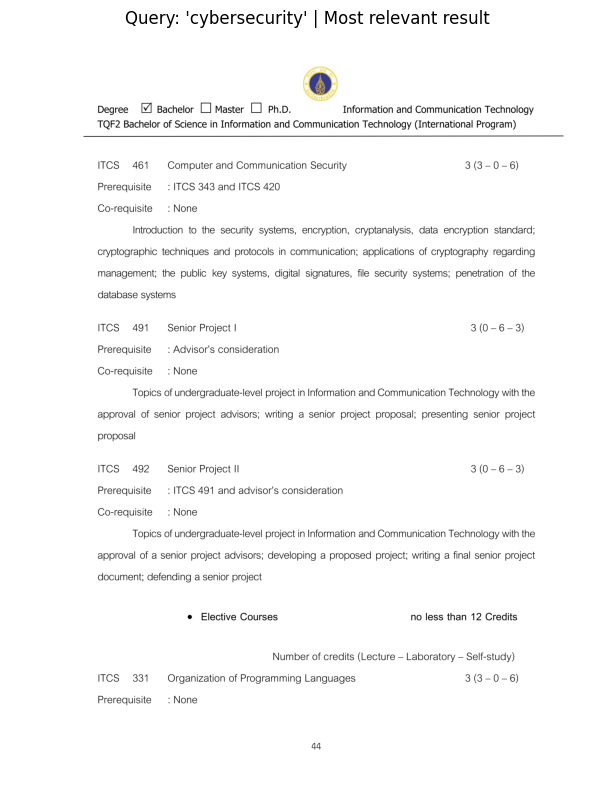

In [303]:
# Open PDF document and load target immediately
import fitz
pdf_path = "curriculum.pdf"
doc = fitz.open(pdf_path)
page = doc.load_page(pageNum - 1)

# Get the image of the page
img = page.get_pixmap(dpi=600)

# Save Image (Optional)
# img.save("output_filename.png")
doc.close()

# Convert pixmap to numpy array
img_array = np.frombuffer(img.samples_mv,
                          dtype=np.uint8).reshape((img.h, img.w, img.n))

# Display the image using matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant result")
plt.axis('off')
plt.show()

### Extra: Vector Search (for similarity)

1. Dot Product
2. Cosine Similarity